<a href="https://www.kaggle.com/code/leonidasemman/creditcard-fraud-detector?scriptVersionId=174309374" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
____
This notebook focuses on applying different machine learning algorithms to detect fraudulent transactions in credit card data. Fraud detection is a critical issue in the financial sector, where timely identification of fraudulent activities can prevent substantial losses for both customers and businesses.

## Overview
We explored three different machine learning methods: 
 - Logistic regression
 - Random forests
 - Decision trees  

The goal is to compare the performance of these methods in predicting whether a credit card transaction is fraudulent or not. By leveraging historical transaction data labeled with fraud indicators, we aim to build robust models capable of accurately identifying fraudulent activities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            precision_recall_fscore_support, roc_curve, auc,
                            classification_report, confusion_matrix)

import random
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- The dataset contains only numerical input variables which are the result of a PCA transformation. 
- Due to confidentiality issues, we have not the original features and more information about the data.
- Features V1, V2, … V28 are the principal components obtained with PCA and the only features which have not been transformed with PCA are 'Time' and 'Amount'.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

- There are no null values in the dataset.

# Data Analysis
_______

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
positive_class = df[df['Class'] == 1].shape[0]/df['Class'].shape[0]
negative_class = 1-positive_class
print(f'{100*positive_class:.3f}%')
print(f'{100*negative_class:.3f}%')

0.173%
99.827%


- The cases of creditcard faud detection are 0.17% of total transactions. 
- The cases of creditcard non-faud detection are 99.83% of total transactions.

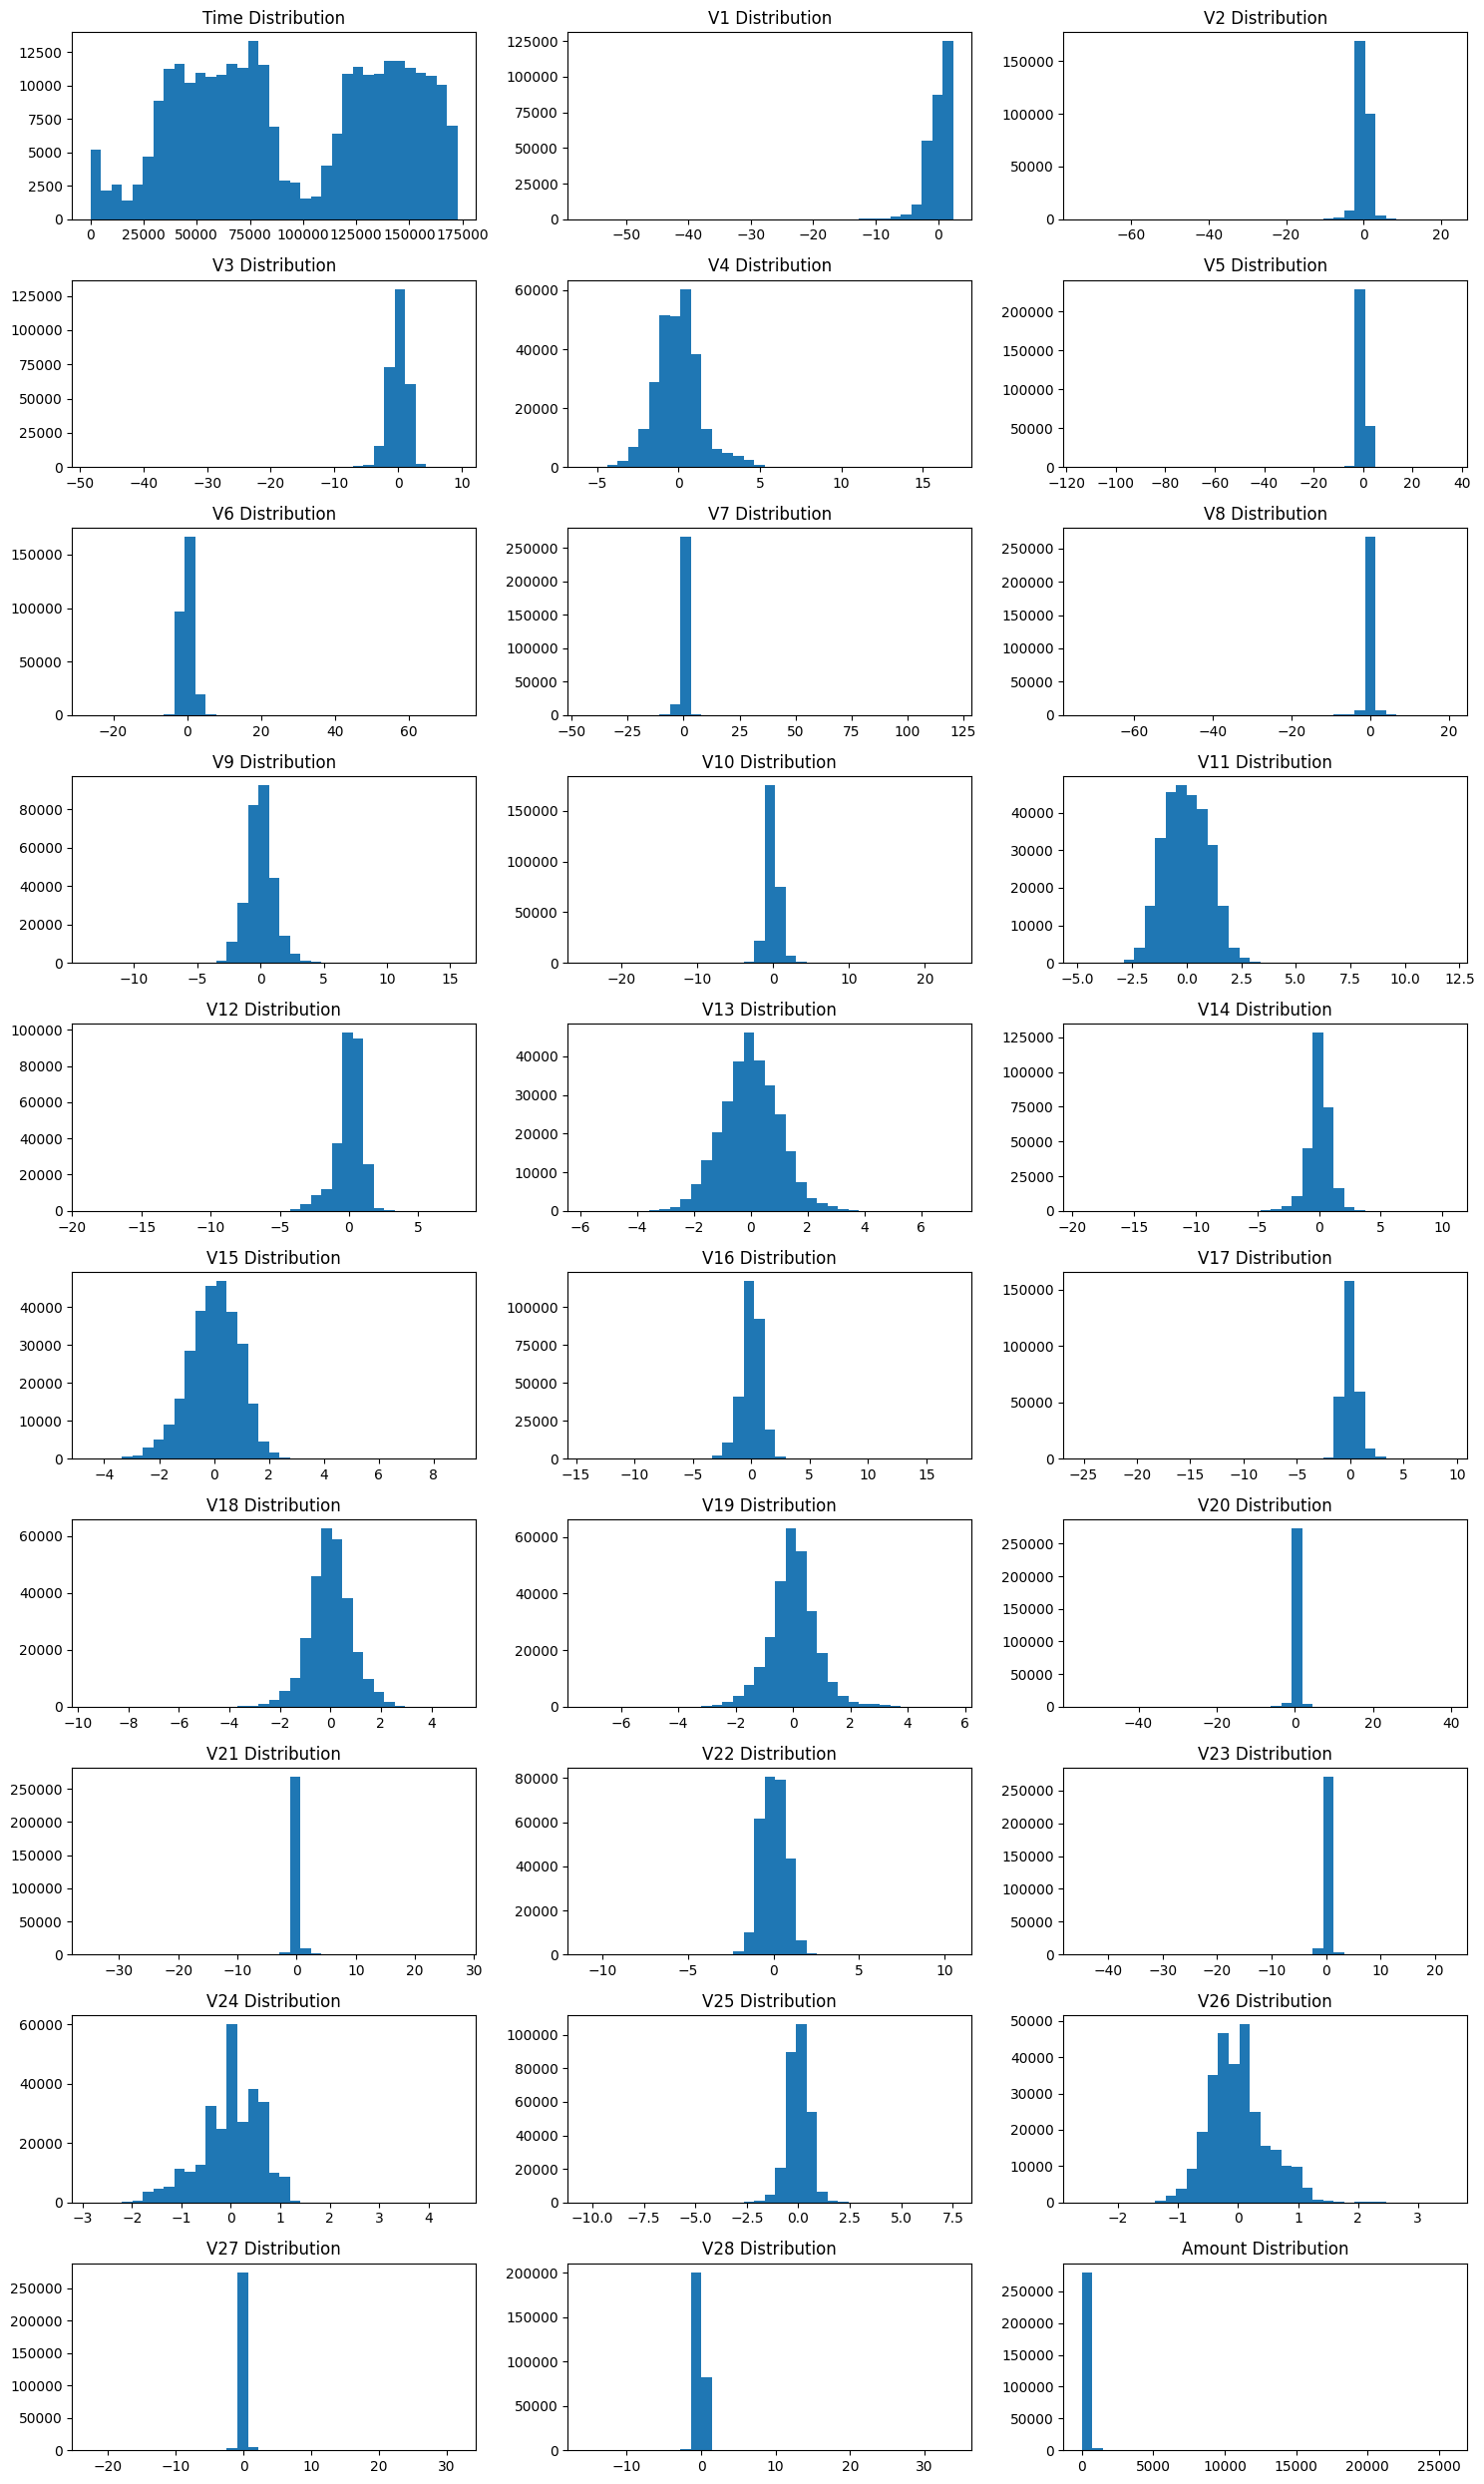

In [8]:
plt.figure(figsize=(15,25))
for i,col in enumerate(df.columns[:-1], 1):
    plt.subplot(10,3,i)
    plt.hist(df[col], bins=35)
    plt.title(f'{col} Distribution')
    
plt.tight_layout()
plt.show()

- Plotting the distributions of each numerical feature in the dataset we observe that almost every variable seems to follow the Gaussian distribution with mean equal to 0. This is because the columns have been scaled before PCA transformation. The only variable that is not 'symmetrical' is the 'Amount' which appears to be affected by extreme values (outliers) and it's clear that has not been scaled before.  

- The variable 'Time' refers to the number of seconds elapsed between the corresponding transaction and the first transaction in the dataset.

In [9]:
# Total Time 
total_secs = df['Time'].max()
total_minutes = total_secs/60
total_hours = total_minutes/60
total_days = total_hours/24

print('The dataset comprises 284,807 transactions recorded over a span of two days.')

The dataset comprises 284,807 transactions recorded over a span of two days.


In [10]:
df[df['Class']==1]['Amount'].sum()

60127.97

- In summary, due to credit card fraud, the bank incurred losses exceeding $60,000 over a span of two days

The variable 'Time' does not provide more meaningful information related to the business problem, so we will drop it and wont include it in our models

In [11]:
df.drop('Time', axis=1).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
pd.set_option('display.max_columns', None)
df.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,-0.006576,0.010832,0.000189,0.012064,0.000161,0.007164,0.011535,0.003887,-0.001178,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [13]:
df.groupby('Class').max()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,172792.0,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,23.745136,10.002190,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.16
1,170348.0,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,12.018913,1.375941,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.87


- The mean transaction amount for a fraud transaction is 122.21, whereas for a non-fraud transaction it is 88.29. 
- The largest fraud transaction amount is 2165.87, in contrast to 25691.16 for a non-fraud transaction. It is evident from the following boxplot that all transactions over 2125 are non-fraudulent.

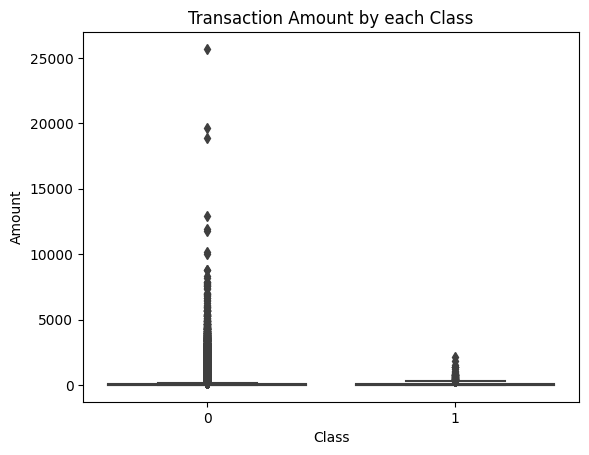

In [14]:
sns.boxplot(x=df['Class'], y=df['Amount'])
plt.title('Transaction Amount by each Class')
plt.show()

### Statistical Test
We will run a statistical test to see if this difference is statistically significant.  


According to __Central Limit Theorem__,  when we repeatedly take independent samples from any population, regardless of its original distribution, and as long as the sample size is sufficiently large, the distribution of sample means will tend to approximate a normal distribution.

Assumptions: 
 - __Independence__: Observations within each sample must be independent of each other
 - __Identically Distributed__: Each observation should come from the same population and have the same probability distribution
 - __Large Sample Size__: The sample size should be sufficiently large (>30)

Since we meet these assumptions, we can claim the central limit therom that the means of the variable 'Amount' follow the gaussian distribution, so we are allowed to use parametric tests. 
We are going to test if the difference of the means of the two different classes is statistically significant in confidence level 95%.

 In a z-test for two independent samples, the z-statistic is typically calculated using the difference between the sample means and the standard error of the difference. Here's the formula:  
 
$$z=\frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$


In [15]:
# Mean of the amount for the non-fraud transactions
x1 = df[df['Class']==0]['Amount'].mean()

# Mean of the amount for the fraud transactions
x2 = df[df['Class']==1]['Amount'].mean()

# Standard Deviation of the amount for the non-fraud transactions
s1 = df[df['Class']==0]['Amount'].std()

# Standard Deviation of the amount for the fraud transactions
s2 = df[df['Class']==1]['Amount'].std()

# Sample size for the non-fraud transactions
n1 = df[df['Class']==0].shape[0]

# Sample size for the fraud transactions
n2 = df[df['Class']==1].shape[0]

# z score
z = (x1 - x2) / np.sqrt((s1**2 / n1) + (s2**2 / n2))
print(f'z statistic: {z:.3f}')

z statistic: -2.929


 $$ Rejected Area = \{ |z| > z_{\frac{a}{2}} \} $$    
 
The value of z being approximately 1.96 corresponds to the critical value for a two-tailed test at a significance level of 𝛼=0.05 is:
 $$ z_{0.025} = 1.96$$


In [16]:
lower_critical_value = -1.96
upper_critical_value = 1.96
if z < lower_critical_value or z > upper_critical_value:
    print("There is a difference between the means of the two populations.")
else:
    print("There is no significant difference between the means of the two populations.")

There is a difference between the means of the two populations.


- Consequently, the mean amount in non-fraud transactions is greater than the mean amount in fraud transactions.

### Downsizing Majority Class for Computational Efficiency
- Dataset Reduction: The dataset reduction involved selecting a subset of 10,000 examples from the original 284807 examples. This downsizing was performed to avoid the computational cost while ensuring a manageable dataset size for training.
- Selective Removal from Majority Class: Notably, examples were removed exclusively from the majority class, which typically represents the negative class (non-fraudulent transactions) in the dataset.

### Considerations
- Impact on Model Performance: It's crucial to acknowledge that downsizing the majority class may lead to some loss of information from this class.   Consequently, there might be implications for the model's ability to accurately detect instances of non-fraudulent transactions.
- Evaluation Metrics: When evaluating model performance, it's advisable to employ metrics that account for class imbalance, such as precision, recall, F1-score, or area under the ROC curve (AUC-ROC).

In [17]:
majority_class_df = df[df['Class'] == 0]
minority_class_df = df[df['Class'] == 1]

random.seed(21) 
random_subset_majority_class = majority_class_df.sample(n=10000, random_state=42)
df = pd.concat([random_subset_majority_class, minority_class_df])

In [18]:
df.shape

(10492, 31)

In [19]:
positive_class = df[df['Class'] == 1].shape[0]/df['Class'].shape[0]
negative_class = 1-positive_class
print(f'{100*positive_class:.2f}% fraud transactions')
print(f'{100*negative_class:.2f}% non-fraud transaction')

4.69% fraud transactions
95.31% non-fraud transaction


- The dataset is still extremely inbalanced, although we kept only the 3% of the instances from the negative class.

# Machine Learning
____
- By using the validation set approach (train-test-split), some of the instances from the positive class will end up in the test set. Since the number of positive examples are significantly small, building a predictive model by using this method will lead to a significant loss of information for the positive class.
- To avoid that, we are going to use the stratify __Cross Validation__.  

K-Fold Cross Validation is a resampling method in which we apply the following steps:
- Divide the dataset in K-Folds.
- Use the first fold as a test set to evaluate our statistical learning model and the rest K-1 to train it.
- Repeat the process K times, so that every time we use a different fold as a test set
- By this process, all instances have been used for training the model K-1 times and for testing exactly once.
- The Cross validation error (CV Error) is the average of the different test set errors.

Stratified cross validation ensures that the proportion of the classes will be the same in every fold of K-fold CV.



In [20]:
X = df.drop('Class', axis=1).values
y = df['Class'].values

In [21]:
# 5 Fold Cross Validation
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

## Model Evaluation
- Since the dataset is extremely inbalanced we will not focus on the accuracy metric. The accuracy tends to be misleading in extremely inbalanced datasets. In datasets like this we expect accuracy be close to 0.99 . We care more about how the model performs in the positive class. Some metrics that we can use are the recall score, precision and AUC-ROC curve.
- When one transaction is classified as Fraud, the value of the __Precision__ can give us the idea of how the system is confident that if it predicts fraud, the transaction is a real fraud.  

   $$ Precision = \frac{True Positives}{True Positives+False Positives} $$

- The value of the __Recall__ can give us an idea of how the system is confident in catching all the fraud
    $$ Recall = \frac{True Positives}{True Positives+False Negatives} $$  
- The __F1 score__ is a metric that combines both precision and recall into a single value. It's the harmonic mean of precision and recall.  
    $$ F1 score = \frac{2*Precision*Recall}{Precision+Recall} $$
- The __ROC curve__ is a graphical representation of the trade-off between true positive rate (recall/sensitivity) and false positive rate (1 - specificity) at various threshold settings for the model.
- The __AUC__ (Area Under the Receiver Operating Characteristic Curve) is a metric used to evaluate the performance of a binary classification model. 
   Range:  AUC values range from 0 to 1, where:
  - AUC = 1 indicates a perfect classifier that achieves perfect separation between the positive and negative classes.
  - AUC = 0.5 indicates a classifier that performs no better than random guessing.  
___
#### Recall is a critical metric for credit card fraud detection because it emphasizes the ability of the model to identify as many fraudulent transactions as possible. For this reason, Recall and AUC-ROC Curve will be the metrics that we will focus in the model evaluation. 

## Logistic Regression

In [22]:
model = LogisticRegression()

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, pos_label=1))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    

In [23]:
print(f"Mean Accuracy: {np.mean(accuracy_scores):.2f}")
print(f"Mean Precision: {np.mean(precision_scores):.2f}")
print(f"Mean Recall: {np.mean(recall_scores):.2f}")
print(f"Mean F1-Score: {np.mean(f1_scores):.2f}")

Mean Accuracy: 0.99
Mean Precision: 0.91
Mean Recall: 0.82
Mean F1-Score: 0.86


- The mean recall score in the 5-fold cross-validation is near 82%. That means, the logistic regression model, on average, correctly detects approximately 82% of the actual credit card frauds.
- The mean precision score in the 5-fold cross validation is near 91% . In other words, if the logistic regression detects one transaction as fraud the probability of being correct is 91 % .

Next, we will attempt to maximize the recall score by adjusting the threshold of the logistic regression model. We will employ cross-validation with various threshold values.

In [24]:
log_model =LogisticRegression()

n_splits=5
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

mean_recall_values = []
mean_precision_values = []
mean_f1_values = []

for threshold in thresholds:
    recall_values = []
    precision_values = []
    f1_values = []

    for train_index, test_index in kfolds.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        log_model.fit(X_train, y_train)
        probabilities = log_model.predict_proba(X_test)[:, 1]

        predictions = (probabilities > threshold).astype(int)
        precision, recall, _, _ = precision_recall_fscore_support(y_test, predictions, average='binary')

        recall_values.append(recall)
        precision_values.append(precision)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_values.append(f1)

    mean_recall = np.mean(recall_values)
    mean_precision = np.mean(precision_values)
    mean_f1 = np.mean(f1_values)

    mean_recall_values.append(mean_recall)
    mean_precision_values.append(mean_precision)
    mean_f1_values.append(mean_f1)

    print(f"Threshold: {threshold:.2f}, Mean Precision: {mean_precision:.2f}, Mean Recall: {mean_recall:.2f}, Mean F1 Score: {mean_f1:.2f}")

print(f"Overall Mean Precision: {np.mean(mean_precision_values):.3f}, Overall Mean Recall: {np.mean(mean_recall_values):.3f}, Overall Mean F1 Score: {np.mean(mean_f1_values):.2f}")


Threshold: 0.10, Mean Precision: 0.53, Mean Recall: 0.86, Mean F1 Score: 0.65
Threshold: 0.20, Mean Precision: 0.70, Mean Recall: 0.85, Mean F1 Score: 0.76
Threshold: 0.30, Mean Precision: 0.78, Mean Recall: 0.84, Mean F1 Score: 0.81
Threshold: 0.40, Mean Precision: 0.87, Mean Recall: 0.82, Mean F1 Score: 0.84
Threshold: 0.50, Mean Precision: 0.91, Mean Recall: 0.82, Mean F1 Score: 0.86
Threshold: 0.60, Mean Precision: 0.93, Mean Recall: 0.81, Mean F1 Score: 0.87
Threshold: 0.70, Mean Precision: 0.96, Mean Recall: 0.81, Mean F1 Score: 0.88
Threshold: 0.80, Mean Precision: 0.97, Mean Recall: 0.81, Mean F1 Score: 0.88
Threshold: 0.90, Mean Precision: 0.98, Mean Recall: 0.80, Mean F1 Score: 0.88
Overall Mean Precision: 0.847, Overall Mean Recall: 0.826, Overall Mean F1 Score: 0.83


In [25]:
best_threshold_index = np.argmax(mean_recall_values)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold: {best_threshold:.2f} with Mean Recall: {np.max(mean_recall_values):.4f} and Mean Precision {mean_precision_values[best_threshold_index]:.4f}")
log_reg_recall = np.max(mean_recall_values)

Best Threshold: 0.10 with Mean Recall: 0.8619 and Mean Precision 0.5292


- We end up with a logistic regression model with a threshold 0.1. For this threshold the model has mean recall 0.861 . That means the model classifies correctly approximately 86% of the posivite classes

## Random Forests

In [26]:
rf_model = RandomForestClassifier()

n_splits=5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    probabilities = rf_model.predict_proba(X_test)[:, 1]
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, pos_label=1))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

In [27]:
print(f"Mean Accuracy: {np.mean(accuracy_scores):.2f}")
print(f"Mean Precision: {np.mean(precision_scores):.2f}")
print(f"Mean Recall: {np.mean(recall_scores):.2f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.2f}")

Mean Accuracy: 0.99
Mean Precision: 0.98
Mean Recall: 0.85
Mean F1 Score: 0.91


### Applying Random Forests with Cross-Validation for Maximizing Recall
After developing a logistic regression model and optimizing the recall score by adjusting the threshold using cross-validation, the next step is to apply a similar approach using Random Forests.
In order to maximize the recall score, we will experiment with different threshold values for classification. By adjusting the threshold, we can trade off between precision and recall, ultimately aiming to achieve a high recall rate while maintaining acceptable precision.

In [28]:
rf_model =RandomForestClassifier()

n_splits=5
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

mean_recall_values = []
mean_precision_values = []
mean_f1_values = []

for threshold in thresholds:
    recall_values = []
    precision_values = []
    f1_values = []

    for train_index, test_index in kfolds.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        rf_model.fit(X_train, y_train)
        probabilities = rf_model.predict_proba(X_test)[:, 1]

        predictions = (probabilities > threshold).astype(int)
        precision, recall, _, _ = precision_recall_fscore_support(y_test, predictions, average='binary')

        recall_values.append(recall)
        precision_values.append(precision)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_values.append(f1)

    mean_recall = np.mean(recall_values)
    mean_precision = np.mean(precision_values)
    mean_f1 = np.mean(f1_values)

    mean_recall_values.append(mean_recall)
    mean_precision_values.append(mean_precision)
    mean_f1_values.append(mean_f1)

    print(f"Threshold: {threshold:.2f}, Mean Precision: {mean_precision:.2f}, Mean Recall: {mean_recall:.2f}, Mean F1 Score: {mean_f1:.2f}")

print(f"Overall Mean Precision: {np.mean(mean_precision_values):.3f}, Overall Mean Recall: {np.mean(mean_recall_values):.3f}, Overall Mean F1 Score: {np.mean(mean_f1_values):.2f}")


Threshold: 0.10, Mean Precision: 0.71, Mean Recall: 0.90, Mean F1 Score: 0.79
Threshold: 0.20, Mean Precision: 0.89, Mean Recall: 0.87, Mean F1 Score: 0.88
Threshold: 0.30, Mean Precision: 0.95, Mean Recall: 0.86, Mean F1 Score: 0.90
Threshold: 0.40, Mean Precision: 0.98, Mean Recall: 0.85, Mean F1 Score: 0.91
Threshold: 0.50, Mean Precision: 0.98, Mean Recall: 0.85, Mean F1 Score: 0.91
Threshold: 0.60, Mean Precision: 0.99, Mean Recall: 0.84, Mean F1 Score: 0.91
Threshold: 0.70, Mean Precision: 0.99, Mean Recall: 0.82, Mean F1 Score: 0.90
Threshold: 0.80, Mean Precision: 1.00, Mean Recall: 0.78, Mean F1 Score: 0.88
Threshold: 0.90, Mean Precision: 1.00, Mean Recall: 0.75, Mean F1 Score: 0.85
Overall Mean Precision: 0.943, Overall Mean Recall: 0.836, Overall Mean F1 Score: 0.88


In [29]:
best_threshold_index = np.argmax(mean_recall_values)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold: {best_threshold:.2f} with Max Recall: {np.max(mean_recall_values):.3f}")
rf_recall = np.max(mean_recall_values)
print(f'Random Forests CV Recall: {rf_recall:.3f}')

Best Threshold: 0.10 with Max Recall: 0.896
Random Forests CV Recall: 0.896


- Similar to logistic regression, we end up with a random forest model with a threshold 0.1. For this threshold the model has mean recall 0.90. That means the model classifies correctly approximately 90% of the posivite classes

## Decision Trees

In [30]:
clf = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [31]:
recall_vals = []
precision_vals = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_model = clf.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    recall_vals.append(recall_score(y_test, y_pred))
    precision_vals.append(precision_score(y_test, y_pred))

print(recall_vals)
print(precision_vals)  

[0.8383838383838383, 0.8383838383838383, 0.8571428571428571, 0.8775510204081632, 0.8877551020408163]
[0.8469387755102041, 0.8469387755102041, 0.8155339805825242, 0.8269230769230769, 0.8446601941747572]


In [32]:
tree_cv_recall = np.mean(recall_vals)
mean_precision = np.mean(precision_vals)
print(f'Mean Recall: {tree_cv_recall:.3f}')
print(f'Mean Precision: {mean_precision:.3f}')

Mean Recall: 0.860
Mean Precision: 0.836


### Applying Decision Trees with Cross-Validation for Maximizing Recall
The next step is to apply a similar approach as before using Decision Trees in order to maximize the recall score. We will experiment with different threshold values for classification. By adjusting the threshold, we can trade off between precision and recall, ultimately aiming to achieve a high recall rate while maintaining acceptable precision.

In [33]:
dt_model = DecisionTreeClassifier()

n_splits=5
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

mean_recall_values = []
mean_precision_values = []
mean_f1_values = []

for threshold in thresholds:
    recall_values = []
    precision_values = []
    f1_values = []

    for train_index, test_index in kfolds.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        dt_model.fit(X_train, y_train)
        probabilities = dt_model.predict_proba(X_test)[:, 1]

        predictions = (probabilities > threshold).astype(int)
        precision, recall, _, _ = precision_recall_fscore_support(y_test, predictions, average='binary')

        recall_values.append(recall)
        precision_values.append(precision)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_values.append(f1)

    mean_recall = np.mean(recall_values)
    mean_precision = np.mean(precision_values)
    mean_f1 = np.mean(f1_values)

    mean_recall_values.append(mean_recall)
    mean_precision_values.append(mean_precision)
    mean_f1_values.append(mean_f1)

    print(f"Threshold: {threshold:.2f}, Mean Precision: {mean_precision:.2f}, Mean Recall: {mean_recall:.2f}, Mean F1 Score: {mean_f1:.2f}")

print(f"Overall Mean Precision: {np.mean(mean_precision_values):.3f}, Overall Mean Recall: {np.mean(mean_recall_values):.3f}, Overall Mean F1 Score: {np.mean(mean_f1_values):.2f}")


Threshold: 0.10, Mean Precision: 0.85, Mean Recall: 0.86, Mean F1 Score: 0.86
Threshold: 0.20, Mean Precision: 0.84, Mean Recall: 0.85, Mean F1 Score: 0.85
Threshold: 0.30, Mean Precision: 0.85, Mean Recall: 0.86, Mean F1 Score: 0.85
Threshold: 0.40, Mean Precision: 0.84, Mean Recall: 0.86, Mean F1 Score: 0.85
Threshold: 0.50, Mean Precision: 0.83, Mean Recall: 0.85, Mean F1 Score: 0.84
Threshold: 0.60, Mean Precision: 0.85, Mean Recall: 0.85, Mean F1 Score: 0.85
Threshold: 0.70, Mean Precision: 0.84, Mean Recall: 0.86, Mean F1 Score: 0.85
Threshold: 0.80, Mean Precision: 0.84, Mean Recall: 0.86, Mean F1 Score: 0.85
Threshold: 0.90, Mean Precision: 0.84, Mean Recall: 0.86, Mean F1 Score: 0.85
Overall Mean Precision: 0.841, Overall Mean Recall: 0.857, Overall Mean F1 Score: 0.85


In [34]:
best_threshold_index = np.argmax(mean_recall_values)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold: {best_threshold:.2f} with Max Recall: {np.max(mean_recall_values):.3f}")
dt_recall = np.max(mean_recall_values)
print(f'Random Forests CV Recall: {dt_recall:.3f}')

Best Threshold: 0.10 with Max Recall: 0.864
Random Forests CV Recall: 0.864


- As it was expected, we end up with a decision tree classifier model with a threshold 0.1. For this threshold the model has mean recall 0.864. That means the model classifies correctly approximately 86% of the posivite classes

# Models Comparison
----
Let's take a look in the __ROC__ Curves of our models and their respective __AUC__ (Area Under the Curve).

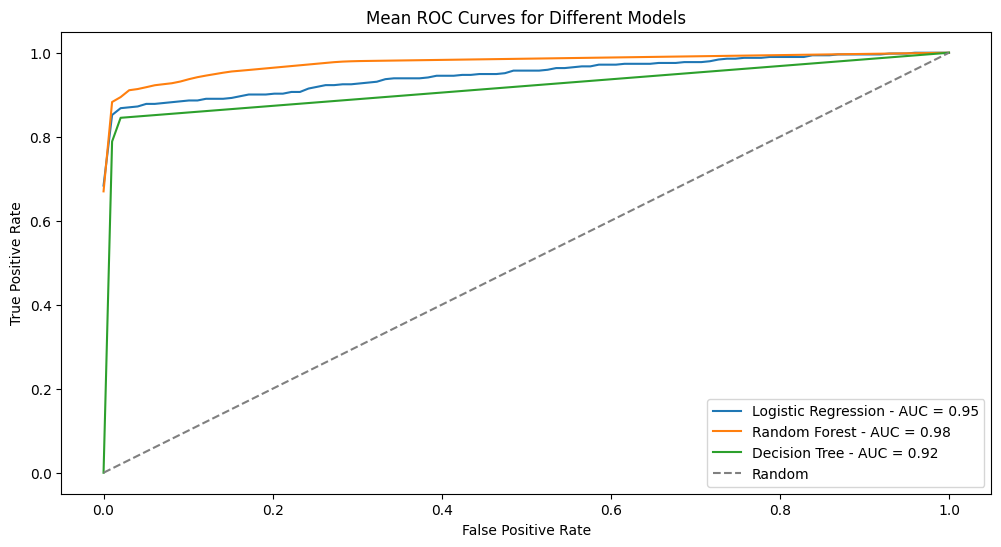

In [35]:
def plot_mean_roc_curve(models, X, y, titles):
    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=365)

    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(12, 6))

    for model, title in zip(models, titles):
        all_tpr = []

        for train_index, test_index in kfolds.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

            model.fit(X_train, y_train)
            probabilities = model.predict_proba(X_test)[:, 1]

            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            interpolated_tpr = np.interp(mean_fpr, fpr, tpr)
            all_tpr.append(interpolated_tpr)

        mean_tpr = np.mean(all_tpr, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)

        plt.plot(mean_fpr, mean_tpr, label=f'{title} - AUC = {mean_auc:.2f}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')

    plt.title('Mean ROC Curves for Different Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

logistic_model = LogisticRegression()
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()

models = [logistic_model, rf_model, dt_model]

titles = ["Logistic Regression", "Random Forest", "Decision Tree"]

plot_mean_roc_curve(models, X, y, titles)

- The ROC Curves above indicate that the Random Forest has superior performance across different threshold values and discriminates better the two classes comparing to Logistic Regression and Decision Trees Classifier.
- This is confirmed by the AUC (Area Under the Curve) value which is the highest for Random Forests (0.95).

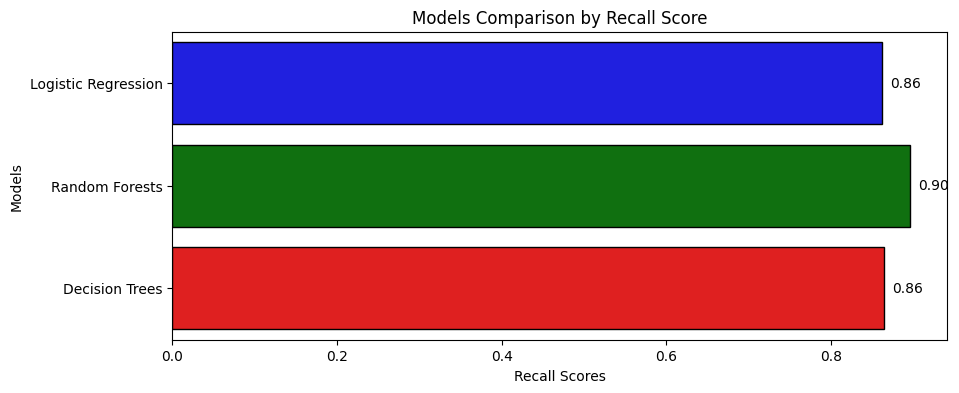

In [36]:
models = ['Logistic Regression', 'Random Forests', 'Decision Trees']
recalls = [log_reg_recall, rf_recall, dt_recall]

plt.figure(figsize=(10, 4))
sns.barplot(x=recalls, y=models, palette=['blue', 'green', 'red'], edgecolor='black')

for i, v in enumerate(recalls):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.xlabel('Recall Scores')
plt.ylabel('Models')
plt.title('Models Comparison by Recall Score')
plt.show()

From the barplot above and the ROC Curve, it's obvious that Random Forests achieved the highest recall score among the three models. This indicates that __Random Forests had the best performance in correctly identifying positive instances__ compared to Logistic Regression and Decision Trees and is chosen as the main model for detecting a fraud transaction. 

In summary, the machine learning model identifies successfully 90% of fraudulent transactions, __resulting in savings of $54,000 within a two-day period and over 2.4 million over three months__.